# Evaluation data frames

These dataframes show the results of the evaluation of the OCR quality, compared with ground truth. This work, conducted by the KB, is documented in the Wikipage [assessment of OCR quality](https://github.com/Giovanni1085/KB_OCR_impact/wiki/Evaluations).

In [1]:
from glob import glob
import jellyfish
import numpy as np
import os, codecs, re
import pandas as pd
from bs4 import BeautifulSoup

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

# magics and warnings
%load_ext autoreload
%autoreload 2
import warnings; warnings.simplefilter('ignore')

import random
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

seed = 43
random.seed(seed)
np.random.seed(seed)

import nltk, gensim, sklearn, spacy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})

In [4]:
# list of data frames

df_anp = pd.read_csv("data_frames_evaluation/full_df_ANP_evaluation.csv", compression="gzip")
df_books = pd.read_csv("data_frames_evaluation/full_df_books_evaluation.csv", compression="gzip")
df_dbnl = pd.read_csv("data_frames_evaluation/full_df_DBNL_OCR_evaluation.csv", compression="gzip")
df_impact = pd.read_csv("data_frames_evaluation/full_df_impact_evaluation.csv", compression="gzip")
df_meertens = pd.read_csv("data_frames_evaluation/full_df_meertens_evaluation.csv", compression="gzip")

#### Take a look

In [5]:
print(df_anp.shape)
df_anp.head(3)

(204, 13)


,Unnamed: 0,Did,Doriginal,gt text,ocr text,CER,WER,WER (order independent),jaccard_coefficient,lookup gt,lookup ocr,levenshtein_dist,levenshtein_dist_normalized
0,0,537184,1937:02:14:1,RADIO 2. Tweed� uitzending van I4 Februari I9...,"b""\r\r\n RADIO 2+ Tweore uitzending van I^ ...",13.12,48.83,42.99,0.37,83.333333,75.54,408,0.14
1,1,537185,1937:02:15:1,RADIO I. Eerste uitzending van I5 Februari I9...,b'\r\r\n RADIO I. Eerste uitzending van 15 ...,16.85,46.70,43.27,0.49,85.169492,88.93,464,0.16
2,2,537186,1937:02:16:1,RADIO I Eerste uitzending van I6 Februari I93...,"b""\r\r\n RADIO I Eerste uitzending van l6 F...",9.51,37.80,34.63,0.51,82.278481,88.17,324,0.11


In [6]:
print(df_books.shape)
df_books.head(3)

(1567, 13)


,Unnamed: 0,Did,Doriginal,ocr text,gt text,CER,WER,WER (order independent),jaccard_coefficient,dictionary lookup gt,dictionary lookup ocr,levenshtein_dist,levenshtein_dist_normalized
0,0,538813,dpo:3077:0213,"\nde Gebeurtenis/en in 1787 enz, voorgevallen,...",de Gebeurtenisſen in I787 enz. voorgevallen. ...,5.20,21.02,20.17,0.58,84.82,80.73,136,0.07
1,1,529591,dpo:113:0070,"\n66 B Y L A G E N,\nfcheep brengen der Goeder...",66 BYLAGEN. fcheep brengen der Goederen en Pe...,3.32,15.66,13.74,0.67,95.61,87.77,104,0.05
2,2,529647,dpo:35:0038.tif,\n£0 ISRAËL IN EGYPTE.\ngezegenden Job; zynde ...,20 ISRAEL IN EGYPTE. gezegenden JOB; zynde ee...,5.35,17.35,16.33,0.65,96.18,89.92,87,0.08


In [7]:
print(df_dbnl.shape)
df_dbnl.head(3)

(219, 15)


,Unnamed: 0,filename,text_ground,genre,subgenre,text_ocr,title,year,edition,CER,WER,WER (order independent),jaccard_coefficient,dictionary lookup gt,dictionary lookup ocr
0,0,_vad003182501,Boekbeschouwing. De gemoedsgesteldheid van Da...,"sec - letterkunde,non-fictie",tijdschrift / jaarboek,"SEM1N 9 ( SIS) s.. B OEKBESCHOUWI ' , vOOR 1 8...",Vaderlandsche letteroefeningen. Jaargang 1825,1825,1ste druk,84.53,79.03,34.03,0.281618,75.44,35.50
1,1,_vad003182401,Boekbeschouwing. Mijne Gronden voor het Chris...,"sec - letterkunde,non-fictie",tijdschrift / jaarboek,"BOIKBESCHOUWING VOOR i824. VARLANDSCHE DE , L...",Vaderlandsche letteroefeningen. Jaargang 1824,1824,1ste druk,53.05,72.53,26.50,0.315151,77.59,39.74
2,2,_taa001taal01,Voorbericht. Indien de waarde eener wetenscha...,sec - taalkunde,tijdschrift / jaarboek,﻿D ETA ALG I D S. D ETA ALG I D S. T IJ D S C ...,De Taalgids. Jaargang 1,1859,1ste druk,82.34,104.89,14.50,0.599973,81.24,68.27


In [8]:
print(df_impact.shape)
df_impact.head(3)

(2000, 26)


,Unnamed: 0,filename,text_ground,text_ocr,word_level_confidence_ocr,text_reocr,word_level_confidence_reocr,word_level_average_confidence_ocr,word_level_average_confidence_reocr,CER_ocr,...,language,jaccard_coefficient_ocr,jaccard_coefficient_reocr,dictionary lookup gt,dictionary lookup ocr,dictionary lookup reocr,levenshtein_dist_ocr,levenshtein_dist_normalized_ocr,levenshtein_dist_reocr,levenshtein_dist_normalized_reocr
0,0,DDD_010197037_001.jp2,"['No.', '9922.', 'Tweede', 'Blad.', 'Vrijdag',...","['JSo.', '9822', 'xTweede', 'Blad.', 'Vrijdag'...","[0.27, 0.27, 0.29, 0.95, 0.98, 1.0, 0.97, 0.67...","['ISO.', '9922', '-Tweede', 'Blad.', 'ss*', 'V...","[0.94, 0.23, 0.97, 0.95, 0.16, 0.97, 0.96, 0.9...",0.719354,0.718463,12.93,...,nl,0.481129,0.487461,89.44,75.36,75.96,3262,0.130480,3118,0.123037
1,1,DDD_011219339_001.jp2,"['De', 'Surinamer', 'Redactie', 'J.', 'WILLEBR...","['De', 'Surinamer', '•v*', 'WILLEBRANDS:i^', '...","[0.96, 0.98, 0.46, 0.48, 0.99, 0.97, 0.99, 0.5...","['Whd^Mmumr', 'Redactie', 'J.', 'WILLEBRANDS',...","[0.25, 0.99, 0.83, 0.84, 0.98, 0.97, 0.99, 0.9...",0.765606,0.889051,27.15,...,nl,0.355100,0.799154,90.90,66.95,87.57,4066,0.264095,348,0.022729
2,2,DDD_011179281_001.jp2,"['DE', 'GRONDWET.', 'Mrs.', 'L.', 'Mulder,', '...","['DE', 'GRONDWET.', 'Mrs.', '3L..', 'Mulder,',...","[0.96, 0.98, 0.95, 0.52, 0.97, 0.41, 0.34, 0.9...","['DE', 'GRONDWET.', 'Mrs.', 'Xj.', 'Melder,', ...","[0.76, 0.97, 0.5, 0.62, 0.97, 0.98, 0.97, 0.74...",0.836059,0.805909,4.26,...,nl,0.677461,0.655997,86.93,78.46,76.01,1015,0.044412,918,0.040655


In [9]:
print(df_meertens.shape)
df_meertens.head(3)

(34808, 17)


,Unnamed: 0,Article_id,Newspaper_id,Identifier,article_identifier,type,title,gt text,ocr text,CER,WER,WER (order independent),jaccard_coefficient,dictionary lookup gt,dictionary lookup ocr,levenshtein_dist,levenshtein_dist_normalized
0,0,6,1,ddd:010728187:mpeg21:p002:a0002,ddd:010728187:mpeg21:a0005,artikel,NEDERLANDEN.,"NEDERLANDEN. Valencijn, den 23 July. Sedert de...","NEDERLANDEN. Vakncijn, den j -> July. Scdeit d...",34.66,49.34,46.10,0.254021,87.99,51.68,2581,0.22
1,1,9,2,ddd:010728188:mpeg21:p001:a0001,ddd:010728188:mpeg21:a0001,artikel,VRANKRYK.,"VRANCKRYCK. PArijs, den 12 Augusti. Den Hertog...","VRANKRYK. PÜAriif , den 12 Den Hertog van Sund...",11.86,37.43,36.84,0.392045,93.10,67.54,123,0.11
2,2,10,2,ddd:010728188:mpeg21:p001:a0002,ddd:010728188:mpeg21:a0002,artikel,DUYTSLAND,"DUYTSLANDT, &amp;c. Straetsburg, den 12 Aug. G...","DUYTSLANDT, & C. Strertil-H,?, den ft Giftere...",31.87,70.23,66.05,0.163569,87.05,55.03,416,0.31


## Visualise results

The dictionary lookup similarity is the only measure which is available for all datasets. We plot it, for both OCr and ground truth, and show its correlation with other measures as available for each dataset.

### Meertens

In [11]:
df_meertens[["CER","WER","WER (order independent)", "jaccard_coefficient", "dictionary lookup ocr", "levenshtein_dist_normalized"]].corr()

,CER,WER,WER (order independent),jaccard_coefficient,dictionary lookup ocr,levenshtein_dist_normalized
CER,1.000000,0.899711,0.879728,-0.675723,-0.560723,0.847722
WER,0.899711,1.000000,0.986240,-0.810082,-0.686075,0.779682
WER (order independent),0.879728,0.986240,1.000000,-0.802535,-0.667095,0.765277
jaccard_coefficient,-0.675723,-0.810082,-0.802535,1.000000,0.857523,-0.810541
dictionary lookup ocr,-0.560723,-0.686075,-0.667095,0.857523,1.000000,-0.675117
levenshtein_dist_normalized,0.847722,0.779682,0.765277,-0.810541,-0.675117,1.000000


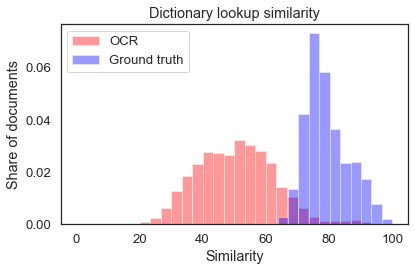

In [12]:
sns.distplot(df_meertens[["dictionary lookup ocr"]].values, norm_hist=True, label="OCR", kde=False, color="red", bins=30)
sns.distplot(df_meertens[["dictionary lookup gt"]].values, norm_hist=True, label="Ground truth", kde=False, color="blue", bins=30)
plt.title("Dictionary lookup similarity")
plt.xlabel("Similarity")
plt.ylabel("Share of documents")
plt.legend()
plt.tight_layout()
plt.savefig("figures/similarity_maartens.png")

### Impact

In [13]:
df_impact[["CER_ocr","WER_ocr","WER (order independent)_ocr", "jaccard_coefficient_ocr", "dictionary lookup ocr", "levenshtein_dist_normalized_ocr"]].corr()

,CER_ocr,WER_ocr,WER (order independent)_ocr,jaccard_coefficient_ocr,dictionary lookup ocr,levenshtein_dist_normalized_ocr
CER_ocr,1.000000,0.897755,0.854261,-0.722205,-0.520542,0.951601
WER_ocr,0.897755,1.000000,0.985484,-0.908134,-0.752422,0.940990
WER (order independent)_ocr,0.854261,0.985484,1.000000,-0.925155,-0.778075,0.915839
jaccard_coefficient_ocr,-0.722205,-0.908134,-0.925155,1.000000,0.859455,-0.793413
dictionary lookup ocr,-0.520542,-0.752422,-0.778075,0.859455,1.000000,-0.583781
levenshtein_dist_normalized_ocr,0.951601,0.940990,0.915839,-0.793413,-0.583781,1.000000


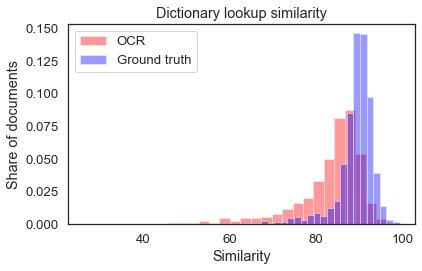

In [14]:
sns.distplot(df_impact[["dictionary lookup ocr"]].values, norm_hist=True, label="OCR", kde=False, color="red", bins=30)
#sns.distplot(df_impact[["dictionary lookup reocr"]].values, norm_hist=True, label="reOCR", kde=False, color="purple", bins=30)
sns.distplot(df_impact[["dictionary lookup gt"]].values, norm_hist=True, label="Ground truth", kde=False, color="blue", bins=30)
plt.title("Dictionary lookup similarity")
plt.xlabel("Similarity")
plt.ylabel("Share of documents")
plt.legend()
plt.tight_layout()
plt.savefig("figures/similarity_impact.png")

### DBNL

In [15]:
df_dbnl[["CER","WER","WER (order independent)", "jaccard_coefficient", "dictionary lookup ocr"]].corr()

,CER,WER,WER (order independent),jaccard_coefficient,dictionary lookup ocr
CER,1.000000,0.826739,0.709254,-0.348190,-0.239735
WER,0.826739,1.000000,0.778687,-0.548721,-0.446704
WER (order independent),0.709254,0.778687,1.000000,-0.491267,-0.241575
jaccard_coefficient,-0.348190,-0.548721,-0.491267,1.000000,0.812703
dictionary lookup ocr,-0.239735,-0.446704,-0.241575,0.812703,1.000000


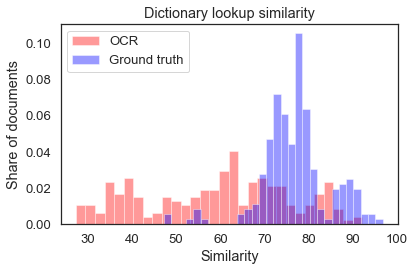

In [16]:
sns.distplot(df_dbnl[["dictionary lookup ocr"]].values, norm_hist=True, label="OCR", kde=False, color="red", bins=30)
sns.distplot(df_dbnl[["dictionary lookup gt"]].values, norm_hist=True, label="Ground truth", kde=False, color="blue", bins=30)
plt.title("Dictionary lookup similarity")
plt.xlabel("Similarity")
plt.ylabel("Share of documents")
plt.legend()
plt.tight_layout()
plt.savefig("figures/similarity_DBNL.png")

### Books

In [17]:
df_books[["CER","WER","WER (order independent)", "jaccard_coefficient", "dictionary lookup ocr", "levenshtein_dist_normalized"]].corr()

,CER,WER,WER (order independent),jaccard_coefficient,dictionary lookup ocr,levenshtein_dist_normalized
CER,1.000000,0.871427,0.849850,-0.250024,-0.160438,0.996232
WER,0.871427,1.000000,0.965775,-0.603115,-0.453135,0.879984
WER (order independent),0.849850,0.965775,1.000000,-0.564924,-0.426423,0.858740
jaccard_coefficient,-0.250024,-0.603115,-0.564924,1.000000,0.791754,-0.271346
dictionary lookup ocr,-0.160438,-0.453135,-0.426423,0.791754,1.000000,-0.177838
levenshtein_dist_normalized,0.996232,0.879984,0.858740,-0.271346,-0.177838,1.000000


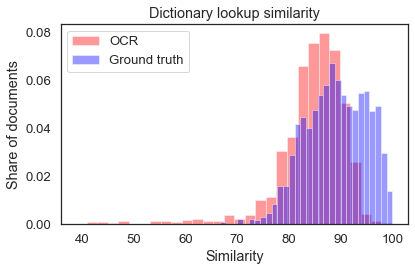

In [18]:
sns.distplot(df_books[["dictionary lookup ocr"]].values, norm_hist=True, label="OCR", kde=False, color="red", bins=30)
sns.distplot(df_books[["dictionary lookup gt"]].values, norm_hist=True, label="Ground truth", kde=False, color="blue", bins=30)
plt.title("Dictionary lookup similarity")
plt.xlabel("Similarity")
plt.ylabel("Share of documents")
plt.legend()
plt.tight_layout()
plt.savefig("figures/similarity_books.png")

### ANP

In [19]:
df_anp[["CER","WER","WER (order independent)", "jaccard_coefficient", "lookup ocr", "levenshtein_dist_normalized"]].corr()

,CER,WER,WER (order independent),jaccard_coefficient,lookup ocr,levenshtein_dist_normalized
CER,1.000000,0.970188,0.961511,-0.585459,-0.472247,0.767849
WER,0.970188,1.000000,0.997205,-0.529608,-0.456029,0.648423
WER (order independent),0.961511,0.997205,1.000000,-0.504085,-0.434179,0.616483
jaccard_coefficient,-0.585459,-0.529608,-0.504085,1.000000,0.762141,-0.799415
lookup ocr,-0.472247,-0.456029,-0.434179,0.762141,1.000000,-0.645799
levenshtein_dist_normalized,0.767849,0.648423,0.616483,-0.799415,-0.645799,1.000000


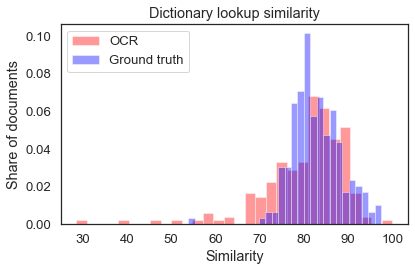

In [20]:
sns.distplot(df_anp[["lookup ocr"]].values, norm_hist=True, label="OCR", kde=False, color="red", bins=30)
sns.distplot(df_anp[["lookup gt"]].values, norm_hist=True, label="Ground truth", kde=False, color="blue", bins=30)
plt.title("Dictionary lookup similarity")
plt.xlabel("Similarity")
plt.ylabel("Share of documents")
plt.legend()
plt.tight_layout()
plt.savefig("figures/similarity_ANP.png")

---